In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.optim.sgd
from helpers import accuracy_fn 


from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_dataset = CIFAR10("data",train=True,transform=transforms.ToTensor(),download=True,target_transform=None) #Each tensor value is in range [0,1]
test_dataset = CIFAR10("data",train=False,transform=transforms.ToTensor(),download=True)

mean = torch.zeros(3)
std = torch.zeros(3)
for im,_ in train_dataset:
    mean += im.mean(dim=[1,2])
    std += im.std(dim=[1,2])

mean /= len(train_dataset.data)
std /= len(train_dataset.data)

class_names = train_dataset.classes
len(train_dataset.data),len(train_dataset.targets), len(test_dataset.data), len(test_dataset.targets)

(50000, 50000, 10000, 10000)

In [3]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]) #Normalized dataset with mean and std of each channel
train_dataset.transform = transform
test_dataset.transform = transform



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290366..2.5574942].


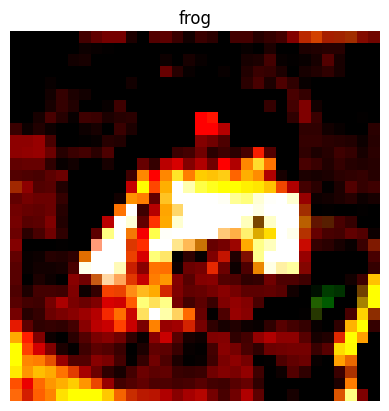

In [4]:
def plot_single_image(image: torch.tensor,label1, label2=None):
    image = image.permute(1,2,0)
    plt.imshow(image)
    plt.title(class_names[label] if not label2 else class_names[label1] + " | " + class_names[label2])
    plt.axis(False)
    plt.show()

image, label = train_dataset[0] #image shape: (3,32,32)
plot_single_image(image,label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290366..2.578489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.731189..2.0068588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2545748..2.3202033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2158055..2.4418902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.021959..2.3783572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0835757..2.5004325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2545748..

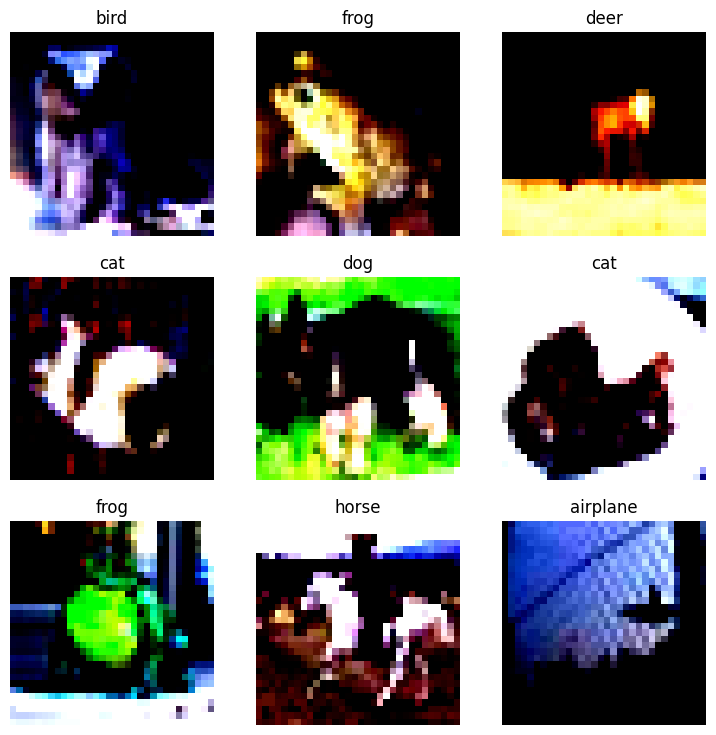

In [5]:
torch.manual_seed(41)
fig = plt.figure(figsize=(9,9))
for i in range(9):
    r_index = torch.randint(low=0,high=len(train_dataset.data),size=[1]).item()
    image, label = train_dataset[r_index] #image shape: (3,32,32)
    image = image.permute(1,2,0)
    fig.add_subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis(False)
    
    

In [6]:
BATCH_SIZE = 4
print(type(train_dataset))
train_dataLoader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataLoader = DataLoader(test_dataset, BATCH_SIZE,shuffle=False)
len(train_dataLoader), len(test_dataLoader),len(train_dataLoader)*BATCH_SIZE,len(test_dataLoader)*BATCH_SIZE

<class 'torchvision.datasets.cifar.CIFAR10'>


(12500, 2500, 50000, 10000)

In [7]:
# # torch.manual_seed(42)
# batch,label = next(iter(train_dataLoader))
# plot_single_image(batch[0],label[0])

In [35]:
class ModelCIFAR0(nn.Module):
    def __init__(self, input_ch, output_ch, hidden_nodes):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_ch, 
                      out_channels=hidden_nodes, 
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_nodes),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, 
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_nodes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_nodes, hidden_nodes*2, 3, padding=1),
            nn.BatchNorm2d(hidden_nodes*2),
            nn.ReLU(),
            nn.Conv2d(hidden_nodes*2, hidden_nodes*2, 3, padding=1),
            nn.BatchNorm2d(hidden_nodes*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_nodes*2,hidden_nodes*4,3,padding=1),
            nn.BatchNorm2d(hidden_nodes*4),
            nn.ReLU(),
            nn.Conv2d(hidden_nodes*4,hidden_nodes*4,3,padding=1),
            nn.BatchNorm2d(hidden_nodes*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(hidden_nodes*4)*4*4, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(class_names))
        )
    
    def forward(self,x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x



model_CNN = ModelCIFAR0(input_ch=train_dataset[0][0].shape[0], output_ch=len(class_names), hidden_nodes=32)


In [36]:
#Forwarding a single image

image, label = next(iter(train_dataLoader))
output1 = model_CNN.block_1(image[0].unsqueeze(dim=0))
output2 = model_CNN.block_2(output1)
output3 = model_CNN.block_3(output2)

output_class = model_CNN.classifier(output3)
output_class.shape
# m  = nn.Flatten()
# output2 = m(output2)
# print(output3.shape)

torch.Size([1, 10])

In [37]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer,
               accuracy_fn):
    
    train_loss, train_acc = 0,0
    
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss = train_loss/len(data_loader)
    train_acc = train_acc/len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_acc

**Codeblock below trains model, possible to also load a pretrained model below**

In [ ]:
#Training and validatidng
torch.manual_seed(42)
from pathlib import Path


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True # if models directory already exists, don't error
)
learn_rate = 0.01

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_CNN.parameters(),lr=learn_rate)

epochs = 50
for epoch in range(epochs):
    print(f'epoch: {epoch} ----------------------------------------------')
    if epoch%10 == 0 and epoch != 0:
        learn_rate /= 10
        optimizer = torch.optim.SGD(params=model_CNN.parameters(),lr = learn_rate)
    train_acc = train_step(model=model_CNN,
               data_loader=train_dataLoader,
               loss_fn=loss_func,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)

    test_acc = test_step(model=model_CNN,
               data_loader=test_dataLoader,
               loss_fn=loss_func,
               accuracy_fn=accuracy_fn)
    
    if epoch%5 == 0:
        MODEL_NAME = f"model_epoch_{epoch}_train_acc({train_acc})_test_acc({test_acc})"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(obj=model_CNN.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

    

epoch: 0 ----------------------------------------------
Train loss: 1.47889 | Train accuracy: 46.20%
Test loss: 1.02289 | Test accuracy: 64.28%

Saving model to: models\model_epoch_0_train_acc(46.202)_test_acc(64.28)
epoch: 1 ----------------------------------------------
Train loss: 1.02121 | Train accuracy: 64.50%
Test loss: 0.81987 | Test accuracy: 71.97%

epoch: 2 ----------------------------------------------
Train loss: 0.84179 | Train accuracy: 71.09%
Test loss: 0.70254 | Test accuracy: 76.24%

epoch: 3 ----------------------------------------------
Train loss: 0.72373 | Train accuracy: 75.13%
Test loss: 0.71120 | Test accuracy: 76.19%

epoch: 4 ----------------------------------------------
Train loss: 0.63677 | Train accuracy: 78.54%
Test loss: 0.63224 | Test accuracy: 78.95%

epoch: 5 ----------------------------------------------
Train loss: 0.56513 | Train accuracy: 80.68%
Test loss: 0.58766 | Test accuracy: 80.85%

Saving model to: models\model_epoch_5_train_acc(80.678)_te

In [ ]:
loaded_model = ModelCIFAR0(input_ch=3, output_ch=len(class_names),hidden_nodes=32)

BEST_PERFORMING_PATH = "C:\RoadToMlGod\Cifar-10-classification\models\model_epoch_10_train_acc(92.248)_test_acc(84.65)"
loaded_model.load_state_dict(torch.load(f=BEST_PERFORMING_PATH))

<All keys matched successfully>

In [ ]:
#Test if loaded behaves as intended
test_step(test_dataLoader,model=loaded_model,loss_fn=loss_func,accuracy_fn=accuracy_fn)

Test loss: 0.50583 | Test accuracy: 84.65%



84.65

In [64]:
def classify_single_image(im: torch.tensor,model: nn.Module, label=None): 
    model.eval()
    with torch.inference_mode():
        y_pred = model(im.unsqueeze(dim=0))
    predic = {"pred": y_pred.argmax(dim=1).item()}
    if label != None:
        predic["true"] = label
        return predic
    else:
        return predic
    

**Visualize predictions by running block below**

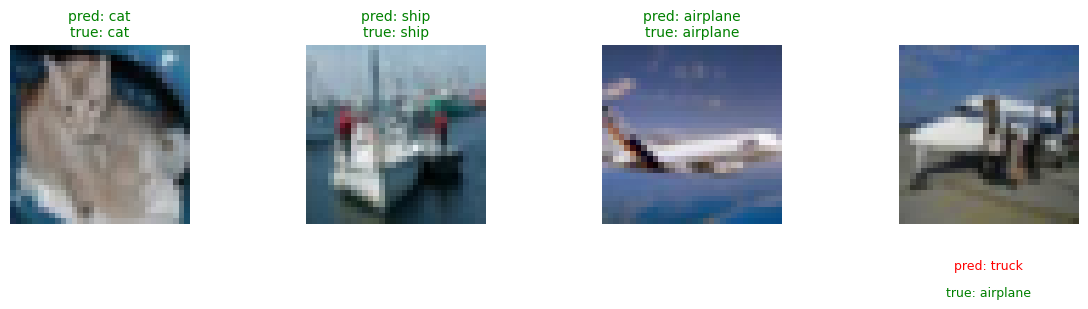

In [75]:

fig = plt.figure(figsize=(12, 3))
for i in range(len(im)):
    ax = fig.add_subplot(1, BATCH_SIZE, i+1)
    idx = torch.randint(0, len(test_dataset), (1,))
    img, label = test_dataset[idx]
    pred_true_map = classify_single_image(img, model=loaded_model, label=label)
    
    # Move channels to last dimension for imshow
    img = img.permute(1, 2, 0)
    
    # Undoes normalization
    img = img * std + mean
    img = img.clip(0, 1)
    
    ax.imshow(img)
    ax.axis('off')
    pred_class = pred_true_map["pred"]
    true_class = pred_true_map["true"]

    if pred_class == true_class:
    # Both correct → single green title
        ax.set_title(
        f"pred: {class_names[pred_class]}\ntrue: {class_names[true_class]}",
        color='green',
        fontsize=10
    )
    else:
    # Wrong → no title, use custom text instead
        ax.set_title("")  # clear title

    # Add separate red and green text below
        ax.text(
        0.5, -0.25,
        f"pred: {class_names[pred_class]}",
        color='red',
        fontsize=9,
        ha='center',
        transform=ax.transAxes
    )
        ax.text(
        0.5, -0.4,
        f"true: {class_names[true_class]}",
        color='green',
        fontsize=9,
        ha='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()